Device: cuda
NPZ keys: ['X_train', 'y_train', 'y_train_int', 'X_val', 'y_val', 'y_val_int', 'X_test', 'y_test', 'y_test_int', 'classes', 'class_weights']
Shapes -> train: (3326, 128, 128, 3), val: (713, 128, 128, 3), test: (713, 128, 128, 3), classes: 9
[ResNet18] Epoch 1/20 (head-only) - train_loss=1.5888 val_loss=1.2777 val_acc=0.5540
[ResNet18] Epoch 2/20 (head-only) - train_loss=1.0848 val_loss=1.0116 val_acc=0.6564
[ResNet18] Epoch 3/20 (head-only) - train_loss=0.9343 val_loss=0.9187 val_acc=0.6957
[ResNet18] Epoch 4/20 - train_loss=0.6506 val_loss=0.4814 val_acc=0.8345
[ResNet18] Epoch 5/20 - train_loss=0.3098 val_loss=0.4150 val_acc=0.8541
[ResNet18] Epoch 6/20 - train_loss=0.1604 val_loss=0.3885 val_acc=0.8808
[ResNet18] Epoch 7/20 - train_loss=0.1123 val_loss=0.5094 val_acc=0.8597
[ResNet18] Epoch 8/20 - train_loss=0.0941 val_loss=0.6264 val_acc=0.8303
[ResNet18] Epoch 9/20 - train_loss=0.0718 val_loss=0.5093 val_acc=0.8696
[ResNet18] Epoch 10/20 - train_loss=0.0772 val_loss=0

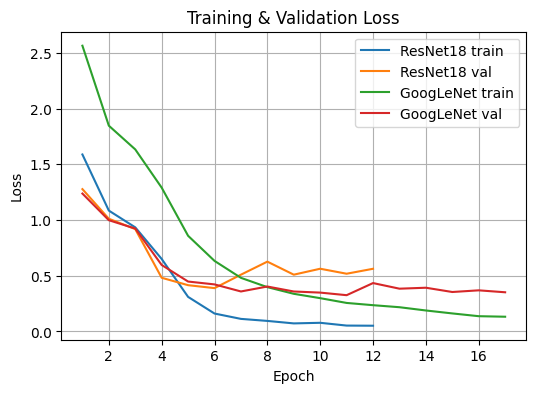


=== Test Metrics (ResNet18) ===
{'acc': np.float64(0.8681626928471248), 'cm': 'see confusion matrix', 'micro_p': 0.8681626928471248, 'macro_p': 0.8701049520643563, 'micro_r': 0.8681626928471248, 'macro_r': 0.8818205597832147}


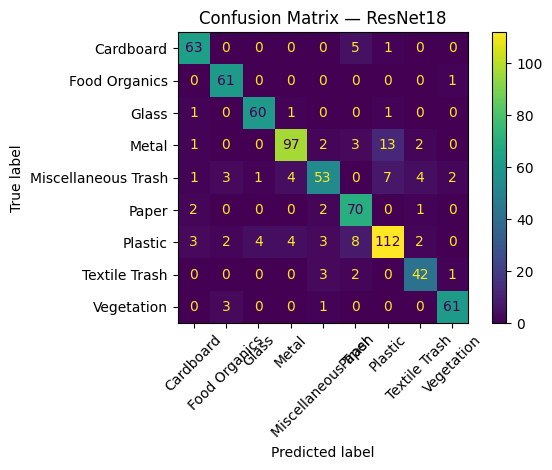


=== Test Metrics (GoogLeNet) ===
{'acc': np.float64(0.879382889200561), 'cm': 'see confusion matrix', 'micro_p': 0.879382889200561, 'macro_p': 0.885590847038852, 'micro_r': 0.879382889200561, 'macro_r': 0.8796876972914406}


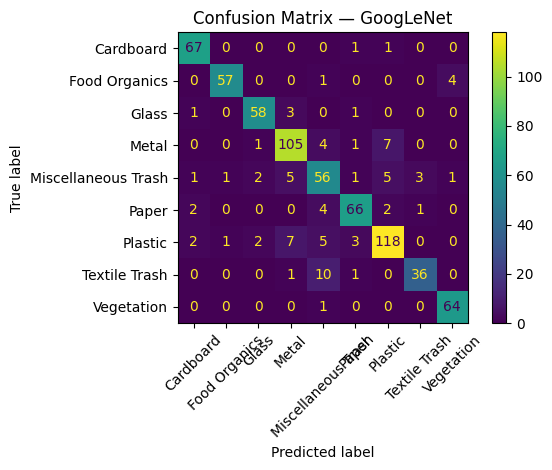


=== Comparison ===
{'model': 'ResNet18', 'test_acc': 0.8681626928471248, 'precision_micro': 0.8681626928471248, 'precision_macro': 0.8701049520643563, 'recall_micro': 0.8681626928471248, 'recall_macro': 0.8818205597832147}
{'model': 'GoogLeNet', 'test_acc': 0.879382889200561, 'precision_micro': 0.879382889200561, 'precision_macro': 0.885590847038852, 'recall_micro': 0.879382889200561, 'recall_macro': 0.8796876972914406}


In [26]:
# =========================
# EN3150 A03 — Part 2 (Transfer Learning + Early Stopping)
# Models: ResNet18 & GoogLeNet — Colab-ready
# =========================

!pip -q install torch torchvision scikit-learn matplotlib

import os, copy, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# 0) DEVICE & SEED
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# 1) CONFIG
NPZ_PATH = "/data/RealWaste/realwaste_prepared.npz"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
FREEZE_EPOCHS = 3         # head-only training before unfreezing
NUM_WORKERS = 0           # avoid Colab/Py3.12 DataLoader cleanup bug
PIN_MEMORY = True
FINETUNE_LR = 1e-4        # smaller LR for backbone
HEAD_LR = 1e-3            # larger LR for new head
OPTIMIZER = "adam"        # "adam" | "sgd" | "sgd_mom"

# Early Stopping config
EARLYSTOP_PATIENCE = 5
EARLYSTOP_MIN_DELTA = 1e-3

# 2) LOAD NPZ (use integer labels if available)
data = np.load(NPZ_PATH, allow_pickle=True)
print("NPZ keys:", list(data.keys()))

def ensure_hw3(img):
    img = np.array(img)
    if img.ndim == 2:              # HxW -> HxWx1
        img = img[..., None]
    if img.ndim == 3 and img.shape[0] in (1,3) and img.shape[-1] not in (1,3):
        img = np.moveaxis(img, 0, -1)
    return img

def stack_xy(X, y):
    X = np.stack([ensure_hw3(x) for x in X])
    y = np.array(y)
    if y.ndim > 1:
        y = y.reshape(-1)
    y = y.astype(np.int64)
    return X, y

# Prefer integer labels *_int if present
if all(k in data for k in ["X_train","y_train_int","X_val","y_val_int","X_test","y_test_int"]):
    X_train, y_train = stack_xy(data["X_train"], data["y_train_int"])
    X_val,   y_val   = stack_xy(data["X_val"],   data["y_val_int"])
    X_test,  y_test  = stack_xy(data["X_test"],  data["y_test_int"])
elif all(k in data for k in ["X_train","y_train","X_val","y_val","X_test","y_test"]):
    X_train, y_train = stack_xy(data["X_train"], data["y_train"])
    X_val,   y_val   = stack_xy(data["X_val"],   data["y_val"])
    X_test,  y_test  = stack_xy(data["X_test"],  data["y_test"])
else:
    raise ValueError("NPZ must contain split arrays (X_train/X_val/X_test and y_* or y_*_int).")

# Optional: class names
class_names = None
if "classes" in data:
    try:
        classes_raw = data["classes"]
        if isinstance(classes_raw, np.ndarray) and classes_raw.dtype == object and classes_raw.size == 1:
            classes_raw = classes_raw.item()
        if isinstance(classes_raw, (list, tuple, np.ndarray)):
            class_names = [str(x) for x in list(classes_raw)]
    except Exception:
        class_names = None

# Optional: class weights (robust parsing; fallback = inverse-frequency)
def compute_inverse_freq_weights(y):
    counts = np.bincount(y, minlength=len(np.unique(y)))
    inv_freq = counts.sum() / (len(counts) * np.clip(counts, 1, None))
    return torch.tensor(inv_freq.astype(np.float32), device=device)

class_weights = None
try:
    if "class_weights" in data:
        cw_raw = data["class_weights"]
        if isinstance(cw_raw, np.ndarray) and cw_raw.dtype == object and cw_raw.size == 1:
            cw_raw = cw_raw.item()

        if isinstance(cw_raw, dict):
            if class_names is not None:
                name_to_w = {str(k): float(v) for k, v in cw_raw.items()}
                cw = np.array([name_to_w.get(str(name), 1.0) for name in class_names], dtype=np.float32)
            else:
                idx_to_w = {int(k): float(v) for k, v in cw_raw.items()}
                kmax = max(idx_to_w.keys()) if idx_to_w else -1
                size = max(kmax + 1, int(len(np.unique(y_train))))
                cw = np.ones(size, dtype=np.float32)
                for k, v in idx_to_w.items(): cw[int(k)] = float(v)
        else:
            cw = np.array(cw_raw, dtype=np.float32).reshape(-1)

        if cw.size == len(np.unique(y_train)):
            class_weights = torch.tensor(cw, dtype=torch.float32, device=device)
        else:
            class_weights = compute_inverse_freq_weights(y_train)
    else:
        class_weights = compute_inverse_freq_weights(y_train)
except Exception:
    class_weights = compute_inverse_freq_weights(y_train)

num_classes = int(len(np.unique(y_train)))
print(f"Shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}, classes: {num_classes}")

# 3) DATASETS & DATALOADERS
imnet_mean = [0.485, 0.456, 0.406]
imnet_std  = [0.229, 0.224, 0.225]

class NpzImageDataset(Dataset):
    def __init__(self, X, y, train=True):
        self.X, self.y = X, y
        if train:
            self.tf = T.Compose([
                T.ToPILImage(),
                T.Resize((IMG_SIZE, IMG_SIZE)),
                T.RandomHorizontalFlip(),
                T.RandomRotation(10),
                T.ToTensor(),
                T.Normalize(imnet_mean, imnet_std),
            ])
        else:
            self.tf = T.Compose([
                T.ToPILImage(),
                T.Resize((IMG_SIZE, IMG_SIZE)),
                T.ToTensor(),
                T.Normalize(imnet_mean, imnet_std),
            ])
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        img = self.X[idx]
        if img.shape[-1] == 1:  # grayscale -> 3ch
            img = np.repeat(img, 3, axis=-1)
        return self.tf(img), int(self.y[idx])

train_ds = NpzImageDataset(X_train, y_train, train=True)
val_ds   = NpzImageDataset(X_val,   y_val,   train=False)
test_ds  = NpzImageDataset(X_test,  y_test,  train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# 4) MODELS (ImageNet-pretrained)
def build_resnet18(num_classes):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_feats = m.fc.in_features
    m.fc = nn.Linear(in_feats, num_classes)
    return m

def build_googlenet(num_classes):
    """
    Load pretrained GoogLeNet (1000-class), then resize ALL classifiers
    to your num_classes. Aux heads can be named fc2 (newer) or fc (older).
    """
    m = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)

    # Main classifier
    m.fc = nn.Linear(m.fc.in_features, num_classes)

    # Aux1 head
    if getattr(m, "aux1", None) is not None:
        if hasattr(m.aux1, "fc2"):
            m.aux1.fc2 = nn.Linear(m.aux1.fc2.in_features, num_classes)
        elif hasattr(m.aux1, "fc"):
            m.aux1.fc = nn.Linear(m.aux1.fc.in_features, num_classes)

    # Aux2 head
    if getattr(m, "aux2", None) is not None:
        if hasattr(m.aux2, "fc2"):
            m.aux2.fc2 = nn.Linear(m.aux2.fc2.in_features, num_classes)
        elif hasattr(m.aux2, "fc"):
            m.aux2.fc = nn.Linear(m.aux2.fc.in_features, num_classes)

    return m

# 5) OPTIMIZER FACTORY (supports differential LR)
def make_optimizer(params_head, params_backbone=None):
    if OPTIMIZER == "adam":
        if params_backbone is None:
            return optim.Adam(params_head, lr=HEAD_LR)
        else:
            return optim.Adam([
                {"params": params_backbone, "lr": FINETUNE_LR},
                {"params": params_head,     "lr": HEAD_LR},
            ])
    elif OPTIMIZER == "sgd":
        if params_backbone is None:
            return optim.SGD(params_head, lr=HEAD_LR)
        else:
            return optim.SGD([
                {"params": params_backbone, "lr": FINETUNE_LR},
                {"params": params_head,     "lr": HEAD_LR},
            ])
    elif OPTIMIZER == "sgd_mom":
        if params_backbone is None:
            return optim.SGD(params_head, lr=HEAD_LR, momentum=0.9, nesterov=True)
        else:
            return optim.SGD([
                {"params": params_backbone, "lr": FINETUNE_LR},
                {"params": params_head,     "lr": HEAD_LR},
            ], momentum=0.9, nesterov=True)
    else:
        raise ValueError("Unknown OPTIMIZER")

# 6) TRAIN / EVAL + EARLY STOPPING
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-3, mode="min", restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.restore_best = restore_best
        self.best = None
        self.num_bad = 0
        self.best_state = None
    def step(self, metric, model):
        improved = False
        if self.best is None:
            improved = True
        else:
            if self.mode == "min":
                improved = (self.best - metric) > self.min_delta
            else:
                improved = (metric - self.best) > self.min_delta
        if improved:
            self.best = metric
            self.num_bad = 0
            if self.restore_best:
                self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.num_bad += 1
        return self.num_bad > self.patience
    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)

def compute_loss_with_aux(outputs, y, criterion):
    """
    GoogLeNet (train mode, aux_logits=True) returns a tuple-like:
      (main_logits, aux2_logits, aux1_logits).
    Combine: loss = main + 0.3*aux1 + 0.3*aux2.
    For other models, 'outputs' is just a tensor.
    """
    if isinstance(outputs, tuple) or hasattr(outputs, "logits"):
        logits = outputs[0] if not hasattr(outputs, "logits") else outputs.logits
        loss = criterion(logits, y)
        if len(outputs) >= 2 and outputs[1] is not None:
            loss = loss + 0.3 * criterion(outputs[1], y)
        if len(outputs) >= 3 and outputs[2] is not None:
            loss = loss + 0.3 * criterion(outputs[2], y)
        return loss, logits
    else:
        return criterion(outputs, y), outputs

def run_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)
    total, correct, running_loss = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train_mode):
            out = model(xb)
            loss, logits = compute_loss_with_aux(out, yb, criterion)
        if train_mode:
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return running_loss/total, correct/total

def train_and_validate(model, freeze_backbone_epochs=FREEZE_EPOCHS, total_epochs=EPOCHS, name="model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()

    # 1) Freeze backbone, train head only
    for p in model.parameters(): p.requires_grad = False
    head_params = []
    for n, p in model.named_parameters():
        if any(k in n for k in [
            "fc.",                 # main head (ResNet/GoogLeNet)
            "aux1.fc2", "aux2.fc2",  # GoogLeNet modern aux heads
            "aux1.fc",  "aux2.fc",   # GoogLeNet older aux heads
            "classifier.",           # other architectures
        ]):
            p.requires_grad = True
            head_params.append(p)
    optimizer = make_optimizer(params_head=head_params)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    for epoch in range(freeze_backbone_epochs):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader,   criterion, optimizer=None)
        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        print(f"[{name}] Epoch {epoch+1}/{total_epochs} (head-only) - "
              f"train_loss={tr_loss:.4f} val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

    # 2) Unfreeze all, fine-tune with early stopping on val_loss
    for p in model.parameters(): p.requires_grad = True
    backbone_params, head_params = [], []
    for n, p in model.named_parameters():
        (head_params if any(k in n for k in [
            "fc.", "aux1.fc2", "aux2.fc2", "aux1.fc", "aux2.fc", "classifier."
        ]) else backbone_params).append(p)
    optimizer = make_optimizer(params_head=head_params, params_backbone=backbone_params)

    es = EarlyStopping(patience=EARLYSTOP_PATIENCE, min_delta=EARLYSTOP_MIN_DELTA, mode="min", restore_best=True)

    for epoch in range(freeze_backbone_epochs, total_epochs):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader,   criterion, optimizer=None)
        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        print(f"[{name}] Epoch {epoch+1}/{total_epochs} - "
              f"train_loss={tr_loss:.4f} val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

        if es.step(va_loss, model):
            print(f"[{name}] Early stopping triggered (patience={EARLYSTOP_PATIENCE}).")
            break

    es.restore(model)
    return model, history

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        out = model(xb)
        logits = out[0] if (isinstance(out, tuple) or hasattr(out, "logits")) else out
        ps.extend(logits.argmax(1).cpu().numpy())
        ys.extend(yb.numpy())
    ys, ps = np.array(ys), np.array(ps)
    acc = (ys == ps).mean()
    cm = confusion_matrix(ys, ps)
    micro_p = precision_score(ys, ps, average="micro", zero_division=0)
    macro_p = precision_score(ys, ps, average="macro", zero_division=0)
    micro_r = recall_score(ys, ps, average="micro", zero_division=0)
    macro_r = recall_score(ys, ps, average="macro", zero_division=0)
    return {"acc":acc, "cm":cm, "micro_p":micro_p, "macro_p":macro_p, "micro_r":micro_r, "macro_r":macro_r}

def plot_history(h1, label1, h2=None, label2=None):
    epochs = range(1, len(h1["train_loss"])+1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, h1["train_loss"], label=f"{label1} train")
    plt.plot(epochs, h1["val_loss"],   label=f"{label1} val")
    if h2:
        e2 = range(1, len(h2["train_loss"])+1)
        plt.plot(e2, h2["train_loss"], label=f"{label2} train")
        plt.plot(e2, h2["val_loss"],   label=f"{label2} val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training & Validation Loss")
    plt.legend(); plt.grid(True); plt.show()

def summarise(name, r):
    return {
        "model": name,
        "test_acc": float(r["acc"]),
        "precision_micro": float(r["micro_p"]),
        "precision_macro": float(r["macro_p"]),
        "recall_micro": float(r["micro_r"]),
        "recall_macro": float(r["macro_r"]),
    }

# 7) BUILD, TRAIN (with early stopping), EVALUATE
resnet18  = build_resnet18(num_classes)
googlenet = build_googlenet(num_classes)

resnet18,  hist_rn = train_and_validate(resnet18,  name="ResNet18")
googlenet, hist_gn = train_and_validate(googlenet, name="GoogLeNet")

plot_history(hist_rn, "ResNet18", hist_gn, "GoogLeNet")

res_rn = evaluate(resnet18,  test_loader)
res_gn = evaluate(googlenet, test_loader)

# 8) CONFUSION MATRICES
labels = class_names if (class_names is not None and len(class_names)==num_classes) else None

print("\n=== Test Metrics (ResNet18) ===")
print({k: (v if k!="cm" else "see confusion matrix") for k,v in res_rn.items()})
disp = ConfusionMatrixDisplay(res_rn["cm"], display_labels=labels)
disp.plot(xticks_rotation=45); plt.title("Confusion Matrix — ResNet18"); plt.tight_layout(); plt.show()

print("\n=== Test Metrics (GoogLeNet) ===")
print({k: (v if k!="cm" else "see confusion matrix") for k,v in res_gn.items()})
disp = ConfusionMatrixDisplay(res_gn["cm"], display_labels=labels)
disp.plot(xticks_rotation=45); plt.title("Confusion Matrix — GoogLeNet"); plt.tight_layout(); plt.show()

# 9) SIDE-BY-SIDE COMPARISON
print("\n=== Comparison ===")
print(summarise("ResNet18", res_rn))
print(summarise("GoogLeNet", res_gn))
